<a href="https://colab.research.google.com/github/DaraSamii/DataDays2021/blob/main/train_category_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dara R Samii Login

In [ ]:
from google.colab import drive

drive.mount("/content/drive",force_remount=True)

%cd /content/drive/MyDrive/DataDays2021/

pwd = %pwd
pwd

Mounted at /content/drive
/content/drive/MyDrive/DataDays2021


'/content/drive/MyDrive/DataDays2021'

**-------------------------------------------------------------------------------------------------------------------------------**

# installing packages

In [ ]:
!pip install "dask[complete]"
!pip install -Uqq fastai
!pip install parsivar

# Imports

In [ ]:
import dask.dataframe as dd
import pandas as pd
import os
from fastai.text.all import *
import pickle

from torch.utils.data import Dataset
from tqdm import tqdm
import torch as T
from fastai.data.core import DataLoaders
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

from helper import utils

# declaring paths

In [ ]:
data_folder = os.path.join(pwd,"data")
final_clicked = os.path.join(data_folder,"final","final_clicked.csv")
final_products = os.path.join(data_folder,"final","final_products.csv")
category_classifier_path = os.path.join(data_folder,"models","category_classifier")

In [ ]:
cdf = dd.read_csv(final_clicked)
cdf.head()

,Unnamed: 0,rank,raw_query,page,product_showed,is_clicked,DAY(datetime),HOUR(datetime),IS_WEEKEND(datetime),MINUTE(datetime),MONTH(datetime),NUM_WORDS(raw_query),WEEKDAY(datetime),YEAR(datetime),products.category_name,products.product_name_normalized,products.sellers_count,products.availabilty_ratio,products.mean_all_price,products.max_all_price,products.min_all_price,products.std_all_price,products.skew_all_price,products.mean_available_price,products.max_available_price,products.min_available_price,products.std_available_price,products.skew_available_price,products.COUNT(clicked_merged),products.PERCENT_TRUE(clicked_merged.is_clicked),products.DAY(first_added_date),products.DAY(last_added_date),products.HOUR(first_added_date),products.HOUR(last_added_date),products.IS_WEEKEND(first_added_date),products.IS_WEEKEND(last_added_date),products.MINUTE(first_added_date),products.MINUTE(last_added_date),products.MONTH(first_added_date),products.MONTH(last_added_date),products.NUM_WORDS(product_name_normalized),products.WEEKDAY(first_added_date),products.WEEKDAY(last_added_date),products.YEAR(first_added_date),products.YEAR(last_added_date),_id
0,0,0,ماشین پژو پارس,0,mnlmg,False,14,5,False,33,4,3,2,2021,سایر لوازم تزئینی خودرو,پارس جلو پهن پژو اکورد طرح نیون چراغ اسپرت بلوری,1,1.0,810000.0,810000.0,810000.0,0.0,0.0,810000.0,810000.0,810000.0,0.0,0.0,31,0.032258,20,20,3,3,False,False,57,57,11,11,10,2,2,2019,2019,6312613
1,1,49,دامن شلواری,2,ydpvn,False,14,14,False,5,4,2,2,2021,شلوار و دامن زنانه,شلواری دامن راحت,1,0.0,599000.0,599000.0,599000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,0.000000,5,5,19,19,False,False,38,38,1,1,3,1,1,2021,2021,6313848
2,2,42,کفش چرم زنانه,1,micot,False,14,5,False,48,4,3,2,2021,کفش و صندل زنانه,کفش چرم طبی کد 428 معراج زنانه,1,1.0,470000.0,470000.0,470000.0,0.0,0.0,470000.0,470000.0,470000.0,0.0,0.0,4,0.000000,27,27,21,21,True,True,3,3,2,2,7,5,5,2021,2021,6314214
3,3,22,وافل ساز,2,mjtxs,False,13,21,False,23,4,2,1,2021,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.0,3500000.0,3500000.0,3500000.0,0.0,0.0,3500000.0,3500000.0,3500000.0,0.0,0.0,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021,6246255
4,4,22,وافل ساز,2,mjtxs,False,13,21,False,23,4,2,1,2021,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.0,3500000.0,3500000.0,3500000.0,0.0,0.0,3500000.0,3500000.0,3500000.0,0.0,0.0,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021,6246256


**-------------------------------------------------------------------------------------------------------------------------------**

# Creating category dataset

In [ ]:
def choose_another(List,real):
    while True:
        choice = random.choice(List)
        if choice != real:
            break
    return choice

def make(df, col_name,count_True=200000,count_False=200000):
    unique = list(set(df[col_name]))
    dd1 = df.copy()
    dd2 = df.copy()
    
    dd1["real"] = True
    
    dd2[col_name] = df.apply(lambda x: choose_another(unique,x[col_name]),axis=1)
    dd2["real"] = False

    dd1 = dd1.sample(frac=1).reset_index(drop=1)[0:count_True]

    dd2 = dd2.sample(frac=1).reset_index(drop=1)[0:count_False]

    return pd.concat([dd1,dd2]).sample(frac=1).reset_index(drop=True)

In [ ]:
df = cdf[cdf["is_clicked"]== True][["raw_query","products.category_name"]].compute()
df

,raw_query,products.category_name
12,پاوربانک خورشیدی,سایر برندهای پاوربانک
54,تخته وایت برد دیوارب,سایر لوازم التحریر
64,ساعت,ساعت و مچ بند هوشمند
70,ماشین,ماشین اصلاح و ریش‌ تراش
77,ابچکان,آبچکان و جاظرفی آشپزخانه
...,...,...
53607,ساعت دیواری,ساعت دیواری٬ رومیزی و تزیینی
53637,کیف,کیف و کوله
53644,لباس پلیس,چراغ خطی و زیر کابینتی
53651,y7p,گوشی هوآوی


In [ ]:
candid_df = make(df,col_name="products.category_name",count_True = 150000,count_False=150000)
candid_df

,raw_query,products.category_name,real
0,A10,گوشی سامسونگ,True
1,پایه دریل,تبلت هوآوی,False
2,ماسک سه بعدی,زیبایی و مراقبت ناخن,False
3,تفنگ ترقه ای,ماشین، قطار، کشتی اسباب بازی,True
4,گردبر فلزی,روغن خوراکی,False
...,...,...,...
299995,ماشین ظرفشویی,کف پوش، دیوار پوش و پارکت,False
299996,درب ضد سرقت,بند انداز برقی,False
299997,لپ تاپ,کانتور و هایلایتر,False
299998,کیف رو دوشی مردانه,ساعت مچی عقربه‌ ای و دیجیتالی,False


## loading vocab

In [ ]:
#if vocab exits:
vocab = pickle.load(open(os.path.join(category_classifier_path,"vocab"),'rb'))
vocab

(#2) [['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '<', '>', '2', '1', 'startquery', 'endquery', 'startcategory', 'endcategory', 'و', 'گوشی', 'سایر', 'لوازم', '،', 'سامسونگ', 'بازی', 'جانبی', 'شیائومی', 'خودرو', 'ساعت', 'ماشین', 'مردانه', 'کیف', 'برقی', 'زنانه', 'کفش', 'لپ\u200cتاپ', 'تبلت', 'ابزار', 'برندهای', 'لباس', 'بادی', 'ساز', 'هدفون', 'کامپیوتر', 'اسباب', 'تجهیزات', 'کاور', 'تلویزیون', 'تفنگ', 'اپل', 'هوشمند', 'هدست', 'کنسول', 'یخچال', 'خواب', 'شارژی', 'کولر', 'هندزفری', 'کودک', 'ای', 'دستگاه', 'صندل', 'مودم', 'موبایل', 'هارد', 'سونی', 'آیفون', 'قاب', 'باتری', 'اسپیکر', 'ماسک', 'فریزر', 'بند', 'ایسوس', 'کیبورد', 'پی', 'چراغ', 'ساید', 'صندلی', 'ماوس', 'دوربین', 'ps4', 'دوچرخه', 'موتور', 'دخترانه', 'آشپزخانه', 'ظروف', 'ال', 'کارت', 'گازی', 'فلش', 'میز', 'poco', 'تاپ', '10', 'سرویس', 'روغن', 'پز', 'pro', 'جی', 'نوت', 'گل', 'کشتی', 'ورزشی', 'قطار', 'اسلایم', 'تخت', 'شارژر', 'اصلاح', 'note', 'اسکوتر', 'اسکیت', 'انواع', 'ایکس', 'آرایش', 'مچ', 'قطع

## nlp trasnforms pipeline

In [ ]:
class nlp_pipeline:
    def __init__(self, vocab,):
        self.vocab = vocab
        self.tok = SpacyTokenizer(lang='fa')
        self.num = Numericalize(vocab=self.vocab)

    def encode(self,x):
        x = utils._normalize_text(x)
        x = tokenize1(x, self.tok)
        x = self.num.encodes(x)
        return x

    def decode(self,x):
        x = self.num.decodes(x)
        x = " ".join(x)
        return x

### testing nlp_pipeline

In [ ]:
pipe = nlp_pipeline(vocab=vocab[0])

In [ ]:
we = pipe.encode("سامسونگ گوشی")
we

TensorText([ 2, 22, 18])

In [ ]:
pipe.decode(we)

'xxbos سامسونگ گوشی'

## creating torch dataset

In [ ]:
class categoryDataSet(Dataset):
    def __init__(self, df, query_column_name, category_column_name, vocab ,target_column_name = None,test=False):
        self.df = df.reset_index(drop=True)
        self.query_column_name = query_column_name
        self.category_column_name = category_column_name
        self.test = test
        if test == False:
            self.target_column_name = target_column_name

        self.vocab= vocab

        self.nlp_pipeline = nlp_pipeline(vocab=self.vocab)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, i):
        x1 = self.df[self.query_column_name][i]
        x1_numericalized = self.nlp_pipeline.encode(x1)

        x2 = self.df[self.category_column_name][i]
        x2_numericalized = self.nlp_pipeline.encode(x2)

        if self.test == False:
            y = self.df[self.target_column_name][i]
            return (x1_numericalized,x2_numericalized), y

        else:
            return (x1_numericalized,x2_numericalized)
        

## spliting to valid and train

In [ ]:
candid_df["is_valid"] = False
candid_df["is_valid"] = candid_df["is_valid"].apply(lambda x: True if random.random() < 0.08 else False)

## traind and valid dateset

In [ ]:
train_ds = categoryDataSet(candid_df[candid_df["is_valid"] == False].reset_index(drop=1),"raw_query","products.category_name",vocab=vocab[0],target_column_name="real")
valid_ds = categoryDataSet(candid_df[candid_df["is_valid"] == True],"raw_query","products.category_name",vocab=vocab[0],target_column_name="real")

### testing dataset

In [ ]:
len(train_ds),len(valid_ds)

(276129, 23871)

In [ ]:
def my_collate(batch):
    b = list(zip(*batch))
    x,y = b
    x1,x2 = list(zip(*x))

    return (nn.utils.rnn.pad_sequence(x1).T,  nn.utils.rnn.pad_sequence(x2).T), T.tensor(y).to(T.long)

## creating torch Dataloaders

In [ ]:
train_dl = DataLoader(dataset=train_ds, batch_size=180, shuffle=True, collate_fn=my_collate)
valid_dl = DataLoader(dataset=valid_ds, batch_size=180, shuffle=True, collate_fn=my_collate)

### testing dataloaders

In [ ]:
next(iter(train_dl))

In [ ]:
next(iter(valid_dl))

## fastai Dataloaders wrapper

In [ ]:
fast_category_dl = DataLoaders(train_dl,valid_dl)

# category classifier model

In [ ]:
class CatageoryClassifier(nn.Module):
    def __init__(self, vocab_sz, awd_config, lin_ftrs,joint_layers,joint_drop =0.5):
        super(CatageoryClassifier, self).__init__()
        self.vocab_sz = vocab_sz
        self.awd_config = awd_config 
        self.lin_ftrs = lin_ftrs

        self.joint_drop = joint_drop

        self.awd1 = get_text_classifier(AWD_LSTM,vocab_sz=vocab_sz, n_class=2, config=awd_config,lin_ftrs=lin_ftrs)
        self.awd1[-1].layers = self.awd1[-1].layers[:-1]

        self.awd2 = get_text_classifier(AWD_LSTM,vocab_sz=vocab_sz, n_class=2, config=awd_config,lin_ftrs=lin_ftrs)
        self.awd2[-1].layers = self.awd2[-1].layers[:-1]

        self.joint_layers = [lin_ftrs[-1]*2] + joint_layers + [2]
        linBins = []
        for i in range(0,len(self.joint_layers)-1):
            linBins.append(LinBnDrop(self.joint_layers[i],self.joint_layers[i+1]))

        self.LinBins = nn.Sequential(*linBins)
        self.Softmax = nn.Softmax(dim=1)


    def forward(self,x):
        x1 = self.awd1(x[0])[0]
        x2 = self.awd2(x[1])[0]

        X = T.cat([x1,x2],dim=1)
        X = self.LinBins(X)
        return self.Softmax(X)

    def reset(self):
        self.awd1.reset()
        self.awd2.reset()

In [ ]:
awd_conf = {'bidir': True,
            'emb_sz': 1000,
            'embed_p': 0.05,
            'hidden_p': 0.3,
            'input_p': 0.4,
            'n_hid': 1800,
            'n_layers': 5,
            'output_p': 0.4,
            'pad_token': 1,
            'weight_p': 0.5}

In [ ]:
nn_model  = CatageoryClassifier(len(vocab[0]),awd_config=awd_conf,lin_ftrs=[1000],joint_layers=[500])

In [ ]:
state_dict = T.load(open(os.path.join(category_classifier_path,"models","category_classifier.pth"),'rb'))
nn_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
a = next(iter(train_dl))

In [ ]:
nn_model

In [ ]:
nn_model(a[0])

In [ ]:
loss_func = nn.CrossEntropyLoss()

learn = Learner(fast_category_dl,
                nn_model,
                loss_func = loss_func,
                path = category_classifier_path,
                metrics=[accuracy,error_rate,Recall(),Precision(),F1Score()]).to_fp16()


In [ ]:
grp = ShowGraphCallback
svm = SaveModelCallback(at_end=False,every_epoch=False,reset_on_fit=False,monitor='f1_score',fname="category_classifier",)
esc = EarlyStoppingCallback(patience=3)
rlr = ReduceLROnPlateau(monitor="valid_loss",patience=2,factor=10,)
learn.add_cbs([grp,svm,esc,rlr,ModelResetter])
learn.cbs

(#9) [TrainEvalCallback,Recorder,ProgressCallback,MixedPrecision,ShowGraphCallback,SaveModelCallback,EarlyStoppingCallback,ReduceLROnPlateau,ModelResetter]

SuggestedLRs(valley=1.2022644114040304e-05)

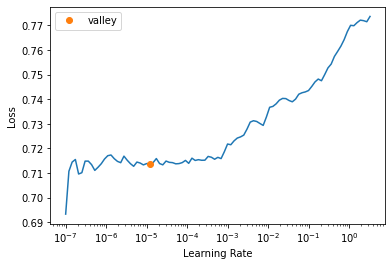

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.697549,0.682275,0.548267,0.451733,0.157107,0.700000,0.256619,01:42
1,0.695707,0.677068,0.580446,0.419554,0.356608,0.638393,0.457600,01:42
2,0.690105,0.682176,0.545792,0.454208,0.142145,0.712500,0.237006,01:42
3,0.677628,0.644087,0.672030,0.327970,0.593516,0.700000,0.642375,01:42
4,0.641357,0.591476,0.724010,0.275990,0.693267,0.735450,0.713736,01:43
5,0.613098,0.569443,0.737624,0.262376,0.630923,0.798107,0.704735,01:43
6,0.592560,0.560471,0.743812,0.256188,0.633416,0.808917,0.710490,01:43
7,0.585336,0.558191,0.742574,0.257426,0.630923,0.808307,0.708683,01:43
8,0.580396,0.555223,0.747525,0.252475,0.623441,0.825083,0.710227,01:42
9,0.573067,0.544060,0.761139,0.238861,0.683292,0.805882,0.739541,01:44


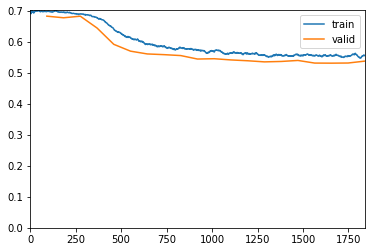

Better model found at epoch 1 with valid_loss value: 0.6770681738853455.
Better model found at epoch 3 with valid_loss value: 0.6440869569778442.
Better model found at epoch 4 with valid_loss value: 0.591476321220398.
Better model found at epoch 5 with valid_loss value: 0.5694431066513062.
Better model found at epoch 6 with valid_loss value: 0.5604711771011353.
Better model found at epoch 7 with valid_loss value: 0.5581914186477661.
Better model found at epoch 8 with valid_loss value: 0.5552231669425964.
Better model found at epoch 9 with valid_loss value: 0.5440600514411926.
Better model found at epoch 11 with valid_loss value: 0.5411637425422668.
Better model found at epoch 12 with valid_loss value: 0.538474977016449.
Better model found at epoch 13 with valid_loss value: 0.534904956817627.
Epoch 15: reducing lr to 1.9954769308440223e-07
Better model found at epoch 16 with valid_loss value: 0.531031608581543.
Better model found at epoch 17 with valid_loss value: 0.5307536721229553.
Ep

In [ ]:
learn.fit_one_cycle(20,1.2e-05)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.526801,0.512694,0.789177,0.210823,0.751057,0.815775,0.782080,05:34
1,0.524630,0.512156,0.788926,0.211074,0.761751,0.808179,0.784279,05:37
2,0.527265,0.509159,0.791557,0.208443,0.758269,0.815023,0.785622,05:38
3,0.524960,0.505399,0.797820,0.202180,0.779408,0.811707,0.795230,05:38
4,0.518774,0.501314,0.802706,0.197294,0.816215,0.796989,0.806487,05:37
5,0.512606,0.492755,0.814982,0.185018,0.809251,0.820888,0.815028,05:39
6,0.512080,0.488034,0.817362,0.182638,0.807262,0.826164,0.816604,05:38
7,0.504497,0.488012,0.817738,0.182262,0.853270,0.798650,0.825057,05:39
8,0.499972,0.476860,0.832895,0.167105,0.837851,0.831647,0.834737,05:37
9,0.496204,0.475580,0.832394,0.167606,0.845063,0.826161,0.835505,05:37


Better model found at epoch 0 with f1_score value: 0.7820795027838924.


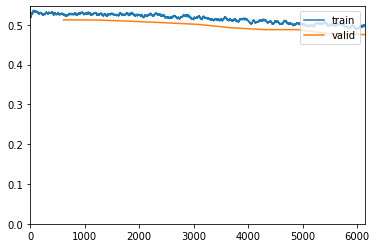

Better model found at epoch 1 with f1_score value: 0.7842785814876456.
Better model found at epoch 2 with f1_score value: 0.78562226230353.
Better model found at epoch 3 with f1_score value: 0.7952296371479319.
Better model found at epoch 4 with f1_score value: 0.8064872834500553.
Better model found at epoch 5 with f1_score value: 0.8150281778334376.
Better model found at epoch 6 with f1_score value: 0.8166037735849055.
Better model found at epoch 7 with f1_score value: 0.8250571119394011.
Better model found at epoch 8 with f1_score value: 0.8347373637264619.
Better model found at epoch 9 with f1_score value: 0.8355052864519301.


epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.491417,0.476631,0.829889,0.170111,0.858493,0.813959,0.835633,05:38
1,0.490054,0.477183,0.828636,0.171364,0.858244,0.812191,0.834583,05:39
2,0.490499,0.477666,0.828886,0.171114,0.864213,0.809080,0.835738,05:37
3,0.491480,0.473417,0.834273,0.165727,0.860731,0.819366,0.839539,05:38
4,0.487022,0.473819,0.834148,0.165852,0.854514,0.822994,0.838458,05:40
5,0.488068,0.471950,0.836903,0.163097,0.868192,0.818907,0.842830,05:36
6,0.491167,0.476482,0.829137,0.170863,0.882119,0.799414,0.838733,05:39
7,0.489220,0.477809,0.829638,0.170362,0.886844,0.797584,0.839849,05:37
8,0.478150,0.472505,0.836027,0.163973,0.876399,0.812731,0.843365,05:37


Better model found at epoch 0 with f1_score value: 0.8356330186395545.


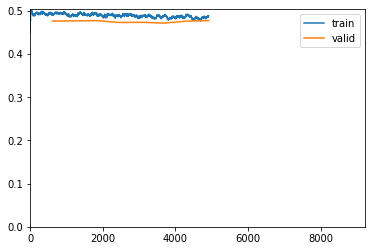

Better model found at epoch 2 with f1_score value: 0.8357383357383358.
Epoch 2: reducing lr to 3.9980297901229455e-07
Better model found at epoch 3 with f1_score value: 0.8395391146149181.
Better model found at epoch 5 with f1_score value: 0.8428295509415741.
Epoch 7: reducing lr to 3.7510673679199316e-07
Better model found at epoch 8 with f1_score value: 0.8433648438434845.
No improvement since epoch 5: early stopping


In [ ]:

learn.fine_tune(15,base_lr=1e-05,freeze_epochs=10)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.485166,0.474403,0.832519,0.167481,0.881870,0.804446,0.841381,05:36
1,0.480559,0.468661,0.838281,0.161719,0.871674,0.818925,0.844477,05:41
2,0.485443,0.462178,0.845296,0.154704,0.860234,0.837125,0.848522,05:41
3,0.482575,0.462844,0.843918,0.156082,0.858742,0.835875,0.847154,05:40
4,0.480230,0.462337,0.846424,0.153576,0.851281,0.844977,0.848117,05:40
5,0.468875,0.465480,0.844920,0.155080,0.879383,0.824435,0.851023,05:40


Better model found at epoch 0 with f1_score value: 0.8413809467315222.


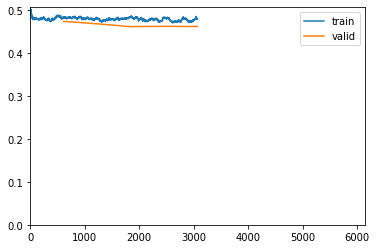

Better model found at epoch 1 with f1_score value: 0.8444765690880616.
Better model found at epoch 2 with f1_score value: 0.8485220164356678.
Epoch 4: reducing lr to 5.273675821853666e-06
Better model found at epoch 5 with f1_score value: 0.8510228640192539.
No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.464653,0.460800,0.847050,0.152950,0.874907,0.830500,0.852125,05:39
1,0.464956,0.459937,0.849054,0.150946,0.883362,0.828358,0.854977,05:40
2,0.467514,0.462445,0.845547,0.154453,0.882368,0.823584,0.851963,05:39
3,0.459287,0.457898,0.851560,0.148440,0.858244,0.848746,0.853469,05:40
4,0.458703,0.455605,0.854441,0.145559,0.869684,0.845707,0.857528,05:39
5,0.460743,0.453520,0.856821,0.143179,0.866700,0.851662,0.859115,05:40
6,0.453521,0.452109,0.857823,0.142177,0.881621,0.843245,0.862006,05:40
7,0.459547,0.452652,0.858073,0.141927,0.851032,0.865015,0.857967,05:41
8,0.452630,0.453838,0.855192,0.144808,0.863218,0.851361,0.857249,05:39


Better model found at epoch 0 with f1_score value: 0.8521254692987769.


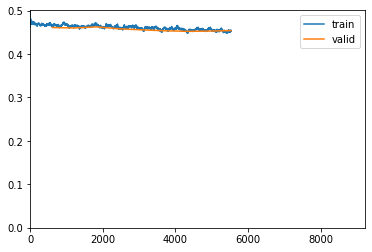

Better model found at epoch 1 with f1_score value: 0.8549765314718979.
Better model found at epoch 4 with f1_score value: 0.8575282000980873.
Better model found at epoch 5 with f1_score value: 0.8591150006162949.
Better model found at epoch 6 with f1_score value: 0.8620060790273556.
Epoch 8: reducing lr to 3.0575094336861303e-06


In [ ]:

learn.fine_tune(15,base_lr=1e-04,freeze_epochs=10)

In [ ]:
test_x = next(iter(valid_dl))[0]

In [ ]:
learn.model((test_x[0].cuda(),test_x[1].cuda()))

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1,0.02,wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time


KeyboardInterrupt: ignored